In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.plot.width=15, repr.plot.height=6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# set seed
set.seed(3456) 
# retrieve data
dataUrl <- "https://raw.githubusercontent.com/rjarvi/dsci_100_group_21/main/heart%2Bdisease/processed.cleveland.data"
colNames <- c("age","sex","cp","restingbps","chollevels","fbs","restecg","maxheartrate","exang","stdepress", "slope", "ca", "thal", "diagnosis")
rawdata <- read.csv(url(dataUrl), header=FALSE, col.names = colNames)

In [3]:
#data cleaning and modification
heartdf <- rawdata |> select(age, restingbps, chollevels, maxheartrate, stdepress, diagnosis)
heartdf <- replace(heartdf, heartdf == "?", NA)
heartdf <- mutate(heartdf, diagnosis = ifelse(diagnosis >= 1, 1, diagnosis))
heartdf <- heartdf |>
    mutate(diagnosis = factor(ifelse(diagnosis == 0, "No", "Yes"), levels = c("No", "Yes")))

heart_split <- initial_split(heartdf, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train_no_class <- select(heart_train, age, restingbps, chollevels, maxheartrate, stdepress)

In [4]:
summary_stats <- heart_train_no_class |>
    sapply(function(x) {
    if(is.numeric(x)) {
        c(
            mean = round(mean(x, na.rm = TRUE), 2),
            sd = round(sd(x, na.rm = TRUE), 2),
            min = round(min(x, na.rm = TRUE), 1),
            max = round(max(x, na.rm = TRUE), 1),
            empty_cells = as.integer(sum(is.na(x))),
            entry_count = as.integer(sum(!is.na(x)))
        )
        } else {
            NULL
        }
})

summary_df <- as.data.frame(summary_stats)
summary_df

,age,restingbps,chollevels,maxheartrate,stdepress
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,55.00,132.27,249.82,149.48,1.02
sd,9.18,18.69,52.80,22.52,1.14
min,29.00,94.00,131.00,88.00,0.00
max,77.00,200.00,564.00,202.00,6.20
empty_cells,0.00,0.00,0.00,0.00,0.00
entry_count,227.00,227.00,227.00,227.00,227.00


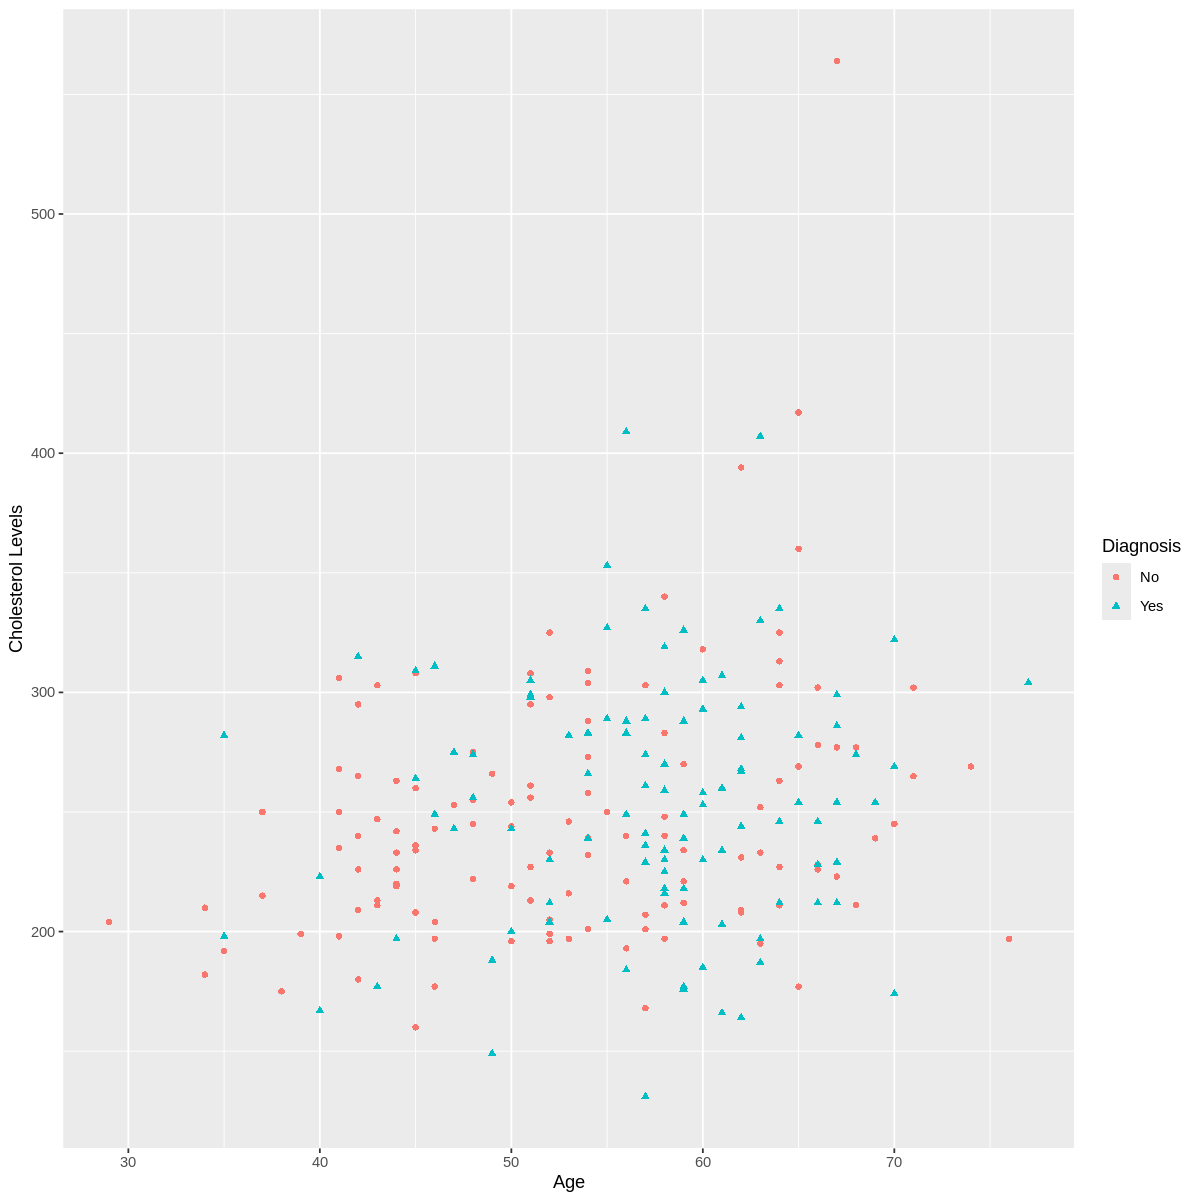

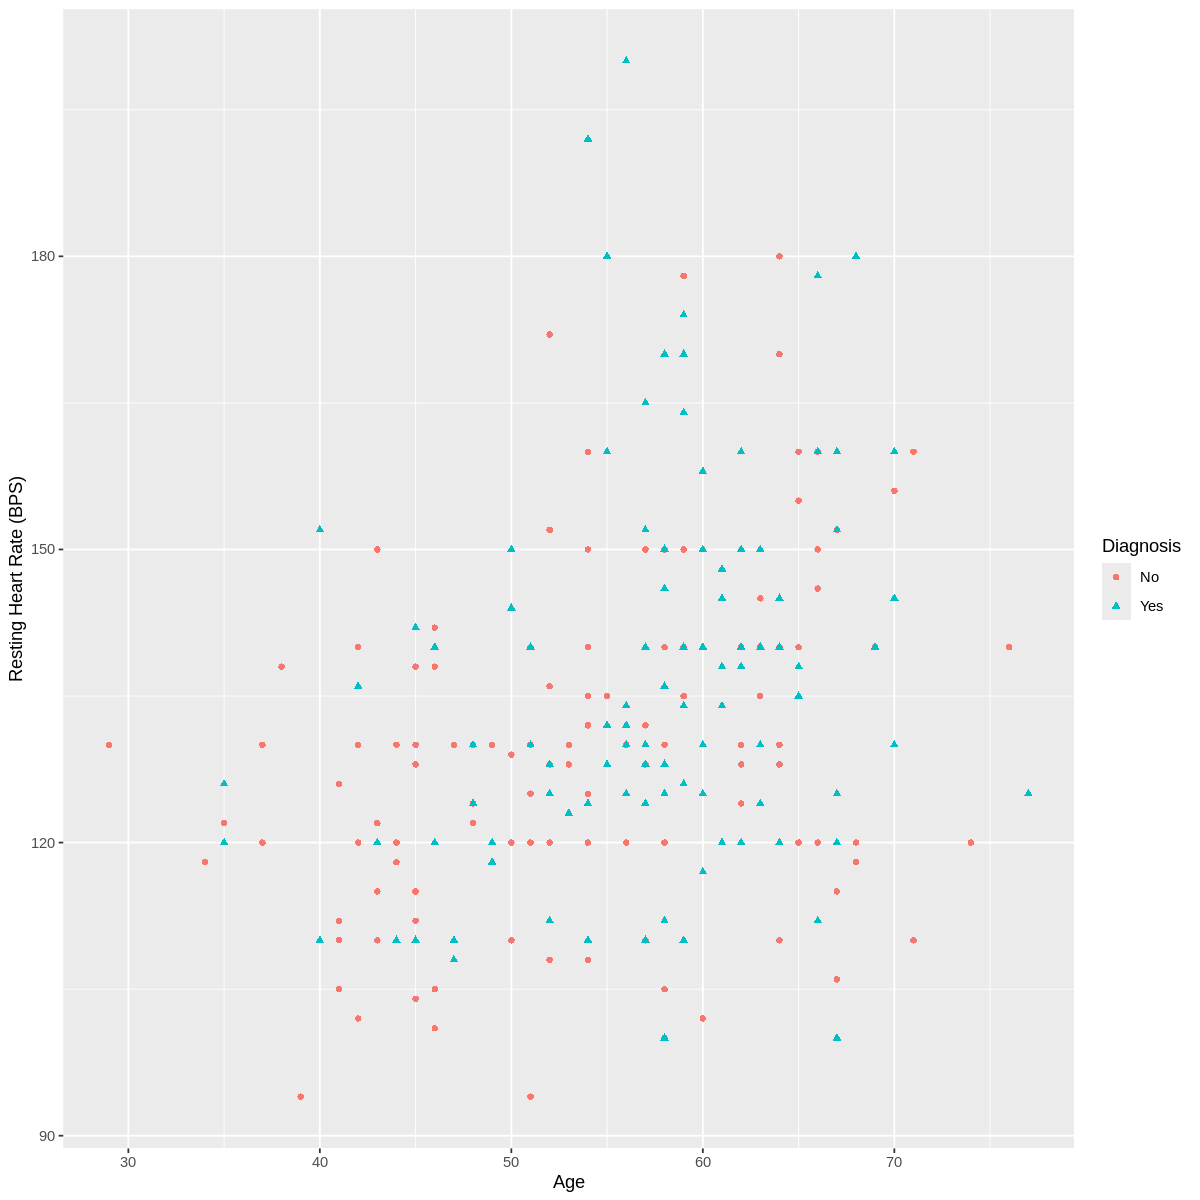

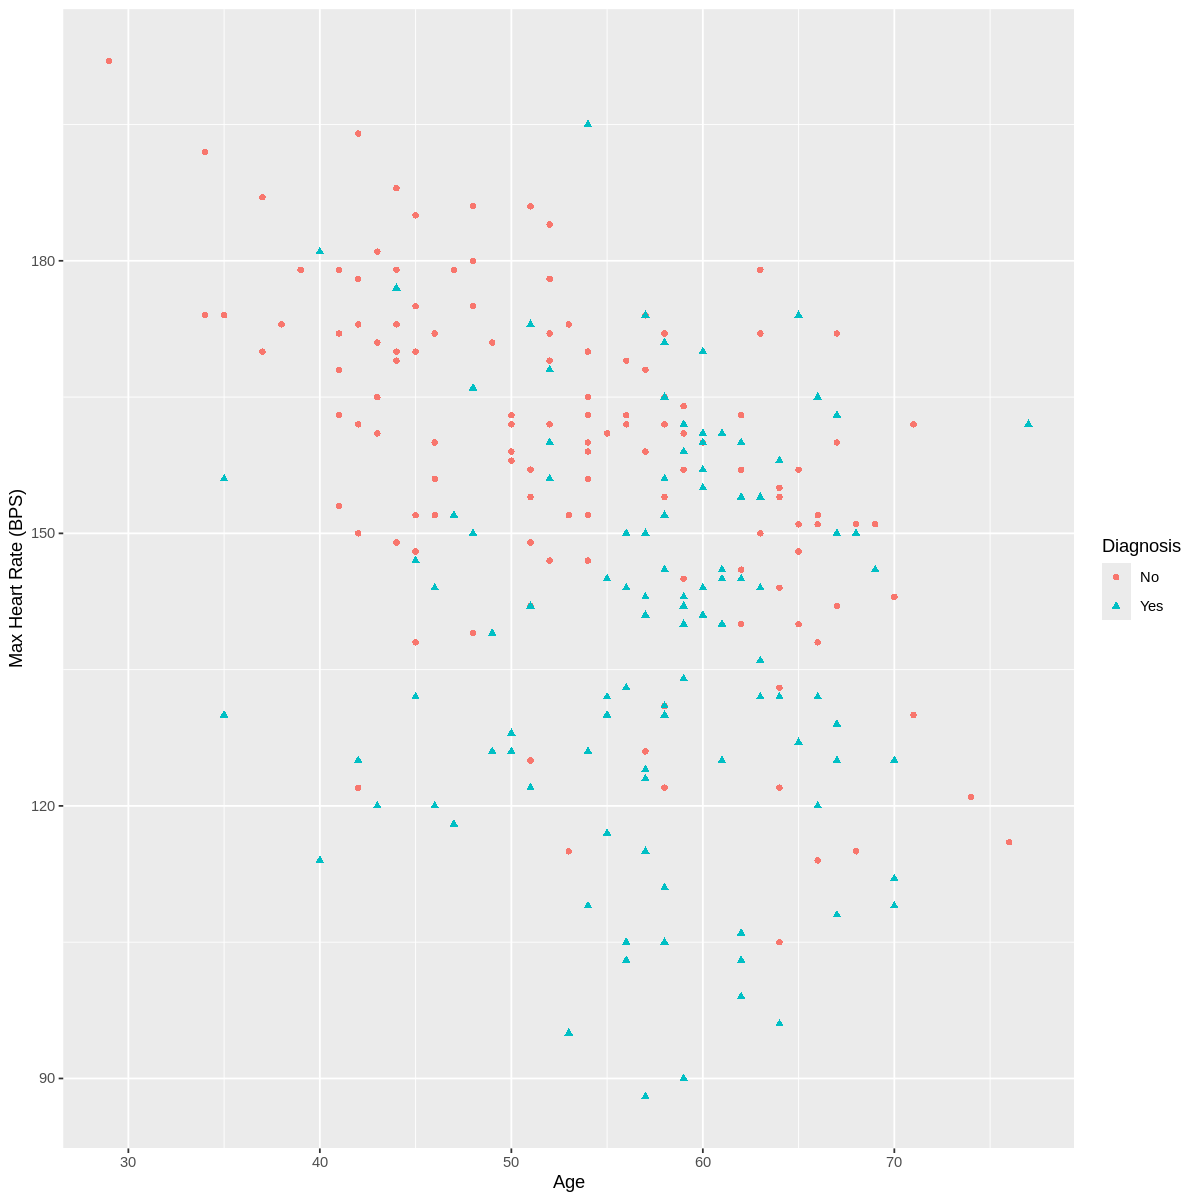

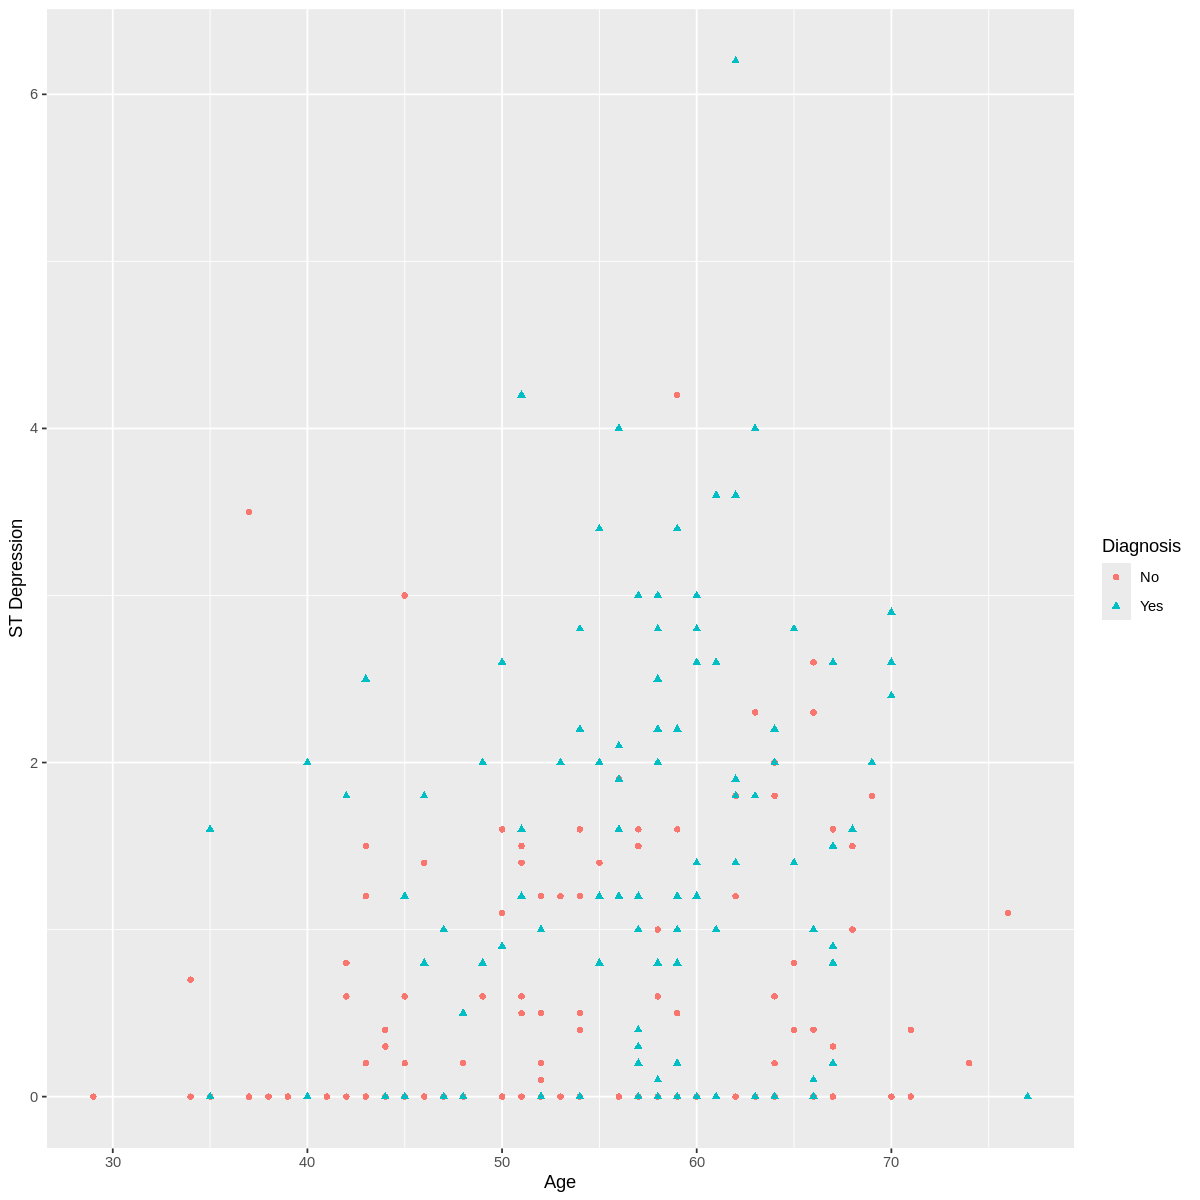

In [29]:
options(repr.plot.width = 10, repr.plot.height = 10) 
#age chol vis

age_chol_plot <- ggplot(heart_train, aes(x = age, y = chollevels)) +
    geom_point(aes(colour = diagnosis, shape = diagnosis)) +
    labs(x = "Age", y = "Cholesterol Levels", colour = "Diagnosis", shape = "Diagnosis")
age_chol_plot

age_restbps_plot <- ggplot(heart_train, aes(x = age, y = restingbps)) +
    geom_point(aes(colour = diagnosis, shape = diagnosis)) +
    labs(x = "Age", y = "Resting Heart Rate (BPS)", colour = "Diagnosis", shape = "Diagnosis")
age_restbps_plot

age_maxbps_plot <- ggplot(heart_train, aes(x = age, y = maxheartrate)) +
    geom_point(aes(colour = diagnosis, shape = diagnosis)) +
    labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Diagnosis", shape = "Diagnosis")
age_maxbps_plot

age_maxbps_plot <- ggplot(heart_train, aes(x = age, y = stdepress)) +
    geom_point(aes(colour = diagnosis, shape = diagnosis)) +
    labs(x = "Age", y = "ST Depression", colour = "Diagnosis", shape = "Diagnosis")
age_maxbps_plot

TODO add analyis, but to start:
Resting heart rate and cholesterol levels do not seem to have strong correlation with heart disease
ST depression mb weakly positively correlated
max heart rate moderately weakly correlated

In [40]:
#recipie stuff


knn_heart_recipe <- recipe(diagnosis ~ age + restingbps + chollevels + maxheartrate +stdepress, data = heart_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())


knn_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

knn_results <- workflow() |>
      add_recipe(knn_heart_recipe) |>
      add_model(knn_heart_spec) |>
      fit(data = heart_train) |>
      tune_grid(resamples = heart_vfold, grid = 20) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")




Warning message:
“tune samples were requested but there were 227 rows in the data. 222 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model01
2,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model02
3,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model03
4,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model04
5,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model05
6,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model06
7,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model07
8,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model08
9,accuracy,binary,0.6888834,10,0.03003763,Preprocessor1_Model09


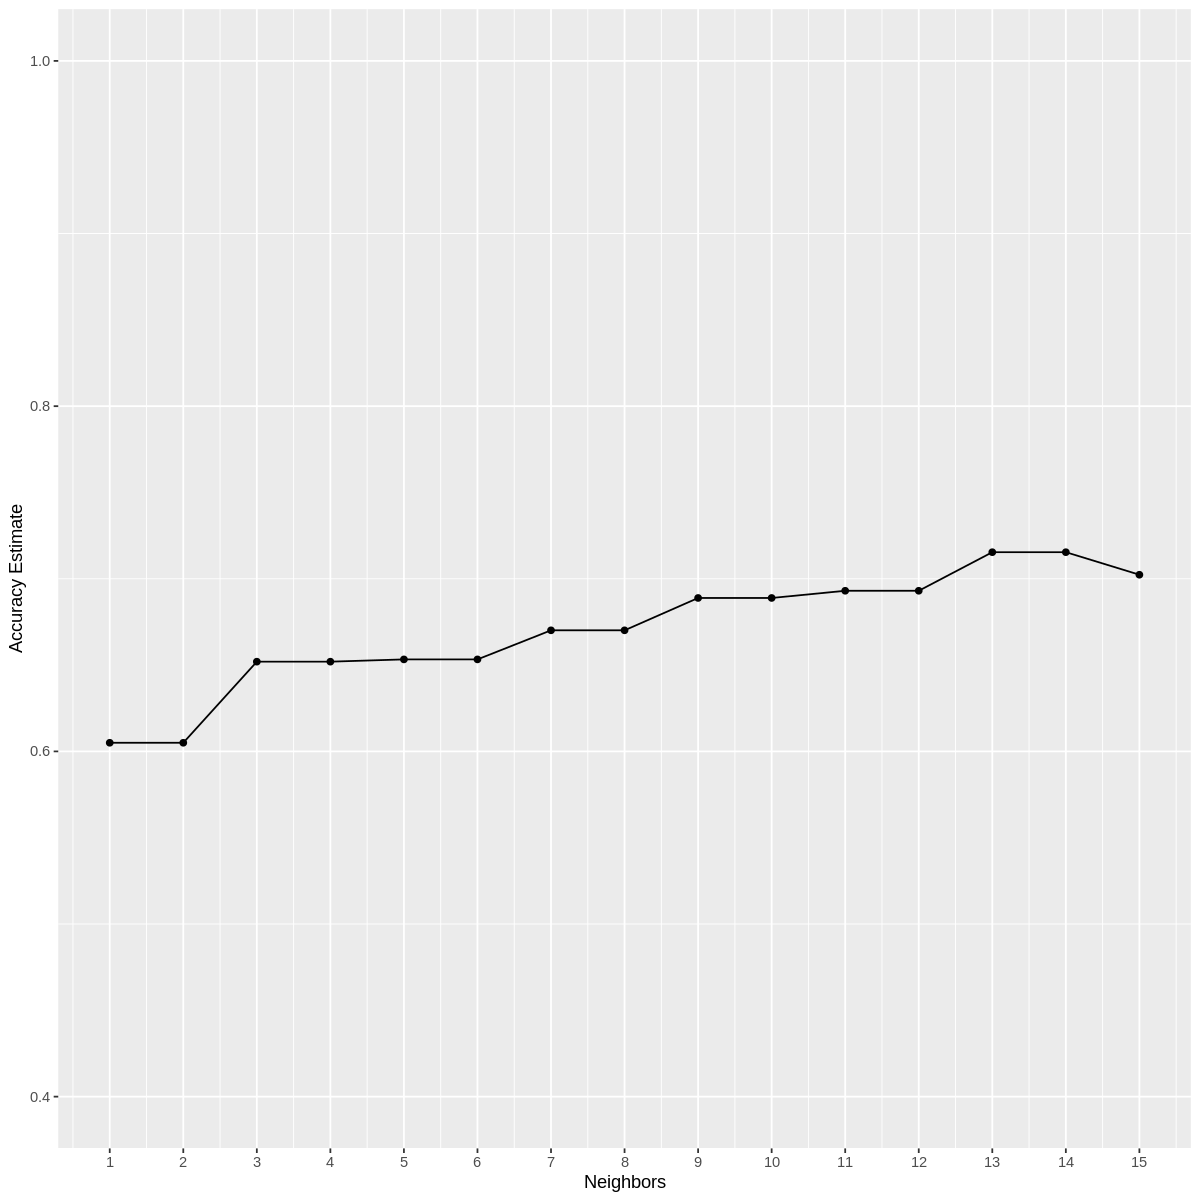

In [41]:
accuracies
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


accuracy_versus_k

In [43]:
#try w just ST depress and max heart rate
knn_heart_recipe_3vars <- recipe(diagnosis ~ age + maxheartrate +stdepress, data = heart_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

heart_vfold2 <- vfold_cv(heart_train, v = 10, strata = diagnosis)

knn_results2 <- workflow() |>
      add_recipe(knn_heart_recipe_3vars) |>
      add_model(knn_heart_spec) |>
      fit(data = heart_train) |>
      tune_grid(resamples = heart_vfold2, grid = 20) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")
accuracies



Warning message:
“tune samples were requested but there were 227 rows in the data. 222 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model01
2,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model02
3,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model03
4,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model04
5,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model05
6,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model06
7,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model07
8,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model08
9,accuracy,binary,0.6888834,10,0.03003763,Preprocessor1_Model09


In [54]:
knn_final_spec_3vars <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_final_fit_3vars <- workflow() |>
    add_recipe(knn_heart_recipe_3vars) |>
    add_model(knn_final_spec_3vars) |>
    fit(data = heart_train)

heart_test_predictions_3vars <- predict(heart_final_fit_3vars , heart_test) |>
      bind_cols(heart_test)

heart_test_predictions_3vars <- heart_test_predictions_3vars |> mutate(predresult = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "TP",
    .pred_class == "No" & diagnosis == "No" ~ "TN",
    .pred_class == "Yes" & diagnosis == "No" ~ "FP",
    .pred_class == "No" & diagnosis == "Yes" ~ "FN",
    TRUE ~ "Other"
  ))

heart_test_predictions_3vars <- heart_test_predictions_3vars |> mutate(predcorrect = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "True",
    .pred_class == "No" & diagnosis == "No" ~ "True",
    .pred_class == "Yes" & diagnosis == "No" ~ "False",
    .pred_class == "No" & diagnosis == "Yes" ~ "False",
    TRUE ~ "Other"
  ))

# heart_test_predictions_3vars

heart_prediction_accuracy_3vars <- heart_test_predictions_3vars |>
        metrics(truth = diagnosis, estimate = .pred_class)             

# heart_prediction_accuracy_3vars

heart_mat_3 <- heart_test_predictions_3vars |> 
      conf_mat(truth = diagnosis, estimate = .pred_class)

heart_mat_3

# confusion_matrix_plot1_3vars <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
#     geom_point(aes(colour = predresult, shape = predresult)) +
#     labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
# confusion_matrix_plot1_3vars

# confusion_matrix_plot2_3vars <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
#     geom_point(aes(colour = predcorrect, shape = predcorrect)) +
#     labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
# confusion_matrix_plot2_3vars



#CONCLUSION - performs a little worse

          Truth
Prediction No Yes
       No  31  13
       Yes 10  22

In [53]:
knn_heart_recipe_4vars <- recipe(diagnosis ~ age + restingbps + chollevels, data = heart_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

heart_vfold3 <- vfold_cv(heart_train, v = 10, strata = diagnosis)

knn_results3 <- workflow() |>
      add_recipe(knn_heart_recipe_4vars) |>
      add_model(knn_heart_spec) |>
      fit(data = heart_train) |>
      tune_grid(resamples = heart_vfold3, grid = 20) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")
accuracies

Warning message:
“tune samples were requested but there were 227 rows in the data. 222 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model01
2,accuracy,binary,0.6049901,10,0.02673790,Preprocessor1_Model02
3,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model03
4,accuracy,binary,0.6519763,10,0.02564375,Preprocessor1_Model04
5,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model05
6,accuracy,binary,0.6532938,10,0.02542110,Preprocessor1_Model06
7,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model07
8,accuracy,binary,0.6701416,10,0.02207691,Preprocessor1_Model08
9,accuracy,binary,0.6888834,10,0.03003763,Preprocessor1_Model09


In [56]:


knn_final_spec_3vars2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_final_fit_3vars2 <- workflow() |>
    add_recipe(knn_heart_recipe_4vars) |>
    add_model(knn_final_spec_3vars2) |>
    fit(data = heart_train)

heart_test_predictions_3vars2 <- predict(heart_final_fit_3vars2 , heart_test) |>
      bind_cols(heart_test)

heart_test_predictions_3vars2 <- heart_test_predictions_3vars2 |> mutate(predresult = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "TP",
    .pred_class == "No" & diagnosis == "No" ~ "TN",
    .pred_class == "Yes" & diagnosis == "No" ~ "FP",
    .pred_class == "No" & diagnosis == "Yes" ~ "FN",
    TRUE ~ "Other"
  ))

heart_test_predictions_3vars2 <- heart_test_predictions_3vars2 |> mutate(predcorrect = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "True",
    .pred_class == "No" & diagnosis == "No" ~ "True",
    .pred_class == "Yes" & diagnosis == "No" ~ "False",
    .pred_class == "No" & diagnosis == "Yes" ~ "False",
    TRUE ~ "Other"
  ))

 heart_test_predictions_3vars2

heart_prediction_accuracy_3vars2 <- heart_test_predictions_3vars2 |>
        metrics(truth = diagnosis, estimate = .pred_class)             

# heart_prediction_accuracy_3vars

heart_mat_32 <- heart_test_predictions_3vars2 |> 
      conf_mat(truth = diagnosis, estimate = .pred_class)

heart_mat_32

#even more bad - lowke

.pred_class,age,restingbps,chollevels,maxheartrate,stdepress,diagnosis,predresult,predcorrect
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
No,41,130,204,172,1.4,No,TN,True
Yes,56,120,236,178,0.8,No,FP,False
Yes,57,120,354,163,0.6,No,FP,False
Yes,63,130,254,147,1.4,Yes,TP,True
No,53,140,203,155,3.1,Yes,FN,False
Yes,57,140,192,148,0.4,No,FP,False
Yes,56,140,294,153,1.3,No,FP,False
Yes,56,130,256,142,0.6,Yes,TP,True
No,48,110,229,168,1.0,Yes,FN,False


          Truth
Prediction No Yes
       No  28  16
       Yes 13  19

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7500000
kap,binary,0.4893918


          Truth
Prediction No Yes
       No  35  13
       Yes  6  22

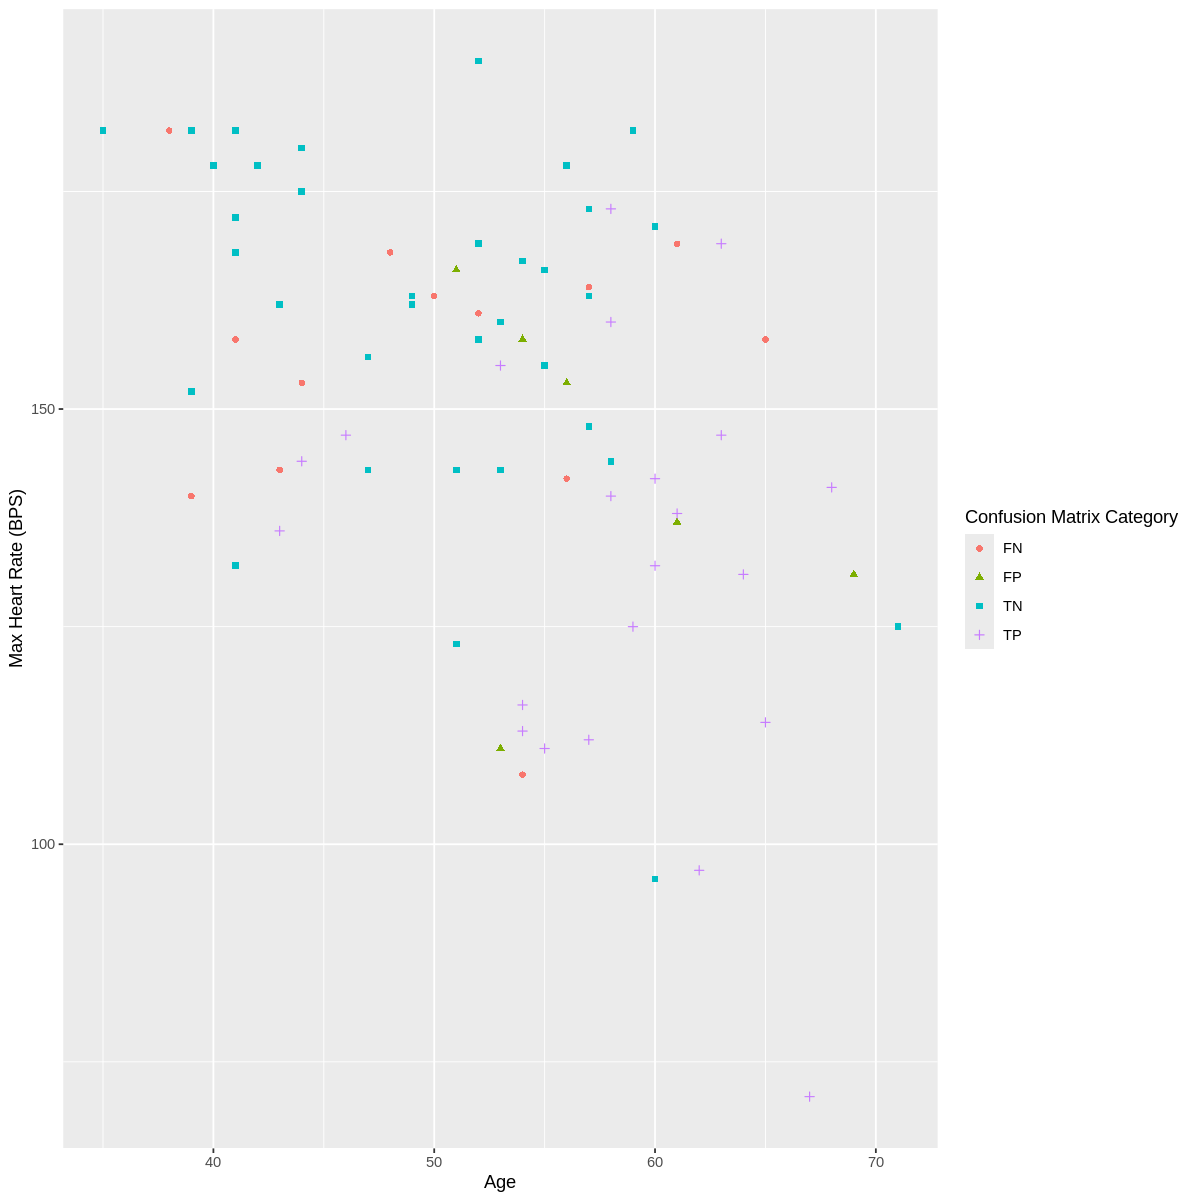

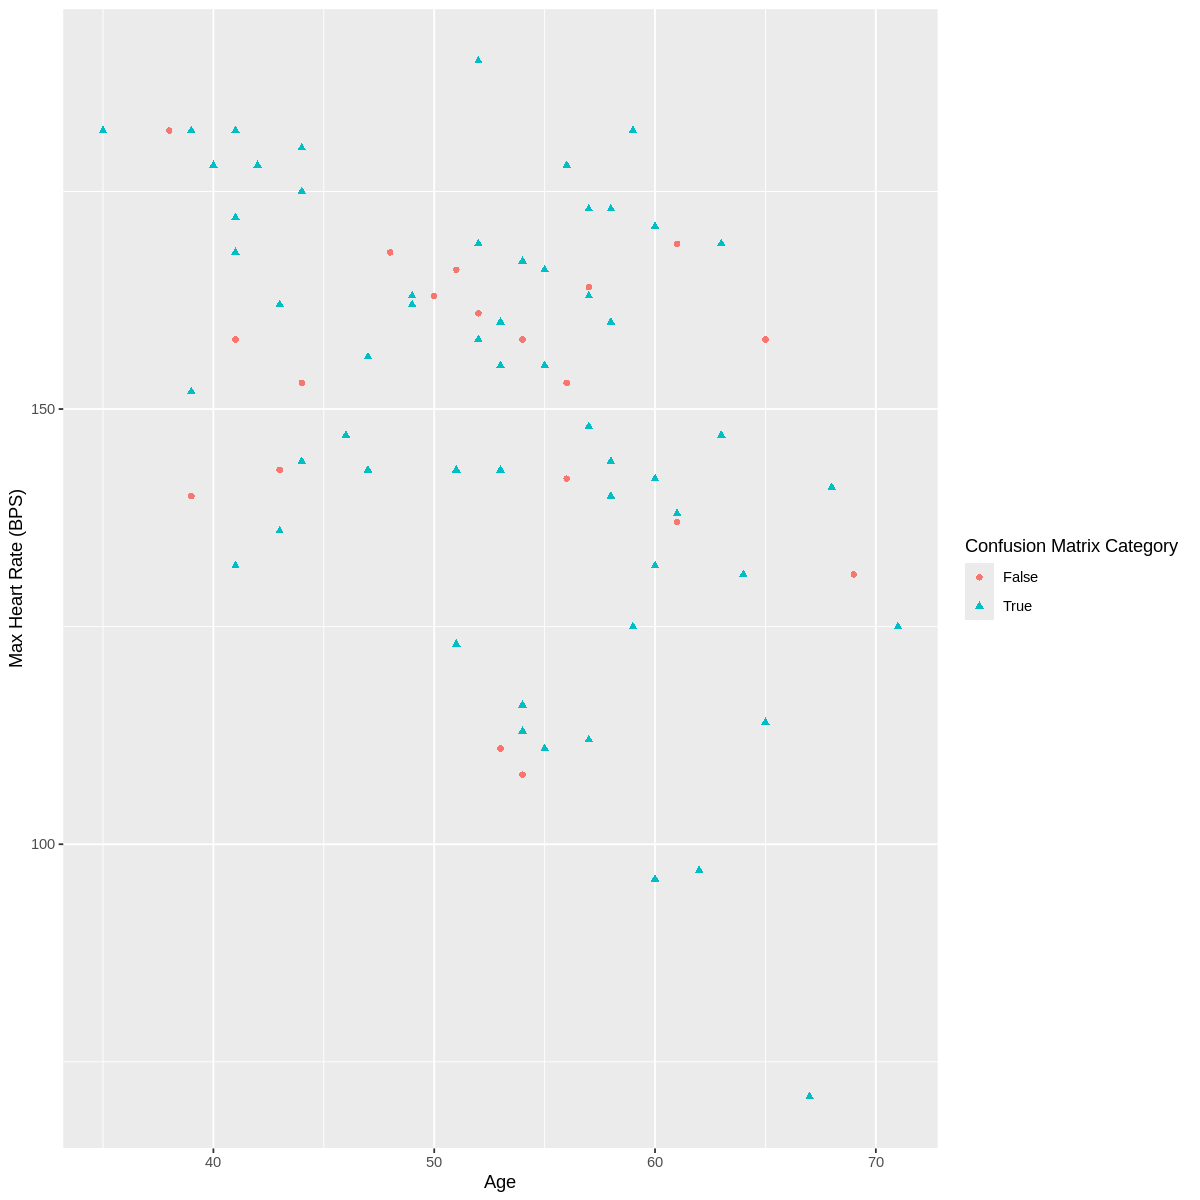

In [39]:
knn_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_final_fit <- workflow() |>
    add_recipe(knn_heart_recipe) |>
    add_model(knn_final_spec) |>
    fit(data = heart_train)


heart_test_predictions <- predict(heart_final_fit , heart_test) |>
      bind_cols(heart_test)

heart_test_predictions <- heart_test_predictions |> mutate(predresult = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "TP",
    .pred_class == "No" & diagnosis == "No" ~ "TN",
    .pred_class == "Yes" & diagnosis == "No" ~ "FP",
    .pred_class == "No" & diagnosis == "Yes" ~ "FN",
    TRUE ~ "Other"
  ))

heart_test_predictions <- heart_test_predictions |> mutate(predcorrect = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "True",
    .pred_class == "No" & diagnosis == "No" ~ "True",
    .pred_class == "Yes" & diagnosis == "No" ~ "False",
    .pred_class == "No" & diagnosis == "Yes" ~ "False",
    TRUE ~ "Other"
  ))

heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = diagnosis, estimate = .pred_class)             

heart_prediction_accuracy

heart_mat <- heart_test_predictions |> 
      conf_mat(truth = diagnosis, estimate = .pred_class)

heart_mat

confusion_matrix_plot1 <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
    geom_point(aes(colour = predresult, shape = predresult)) +
    labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
confusion_matrix_plot1

confusion_matrix_plot2 <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
    geom_point(aes(colour = predcorrect, shape = predcorrect)) +
    labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
confusion_matrix_plot2

#TODO: add more plots here - compare with rest of variables?

Things to do:
